In [1]:
import json

directory = 'vs'
json_filename = f'./dataset/nama/{directory}/label.json'
audio_filename = f'./dataset/nama/{directory}/audio.mp3'


labels_json = json.loads(open(json_filename).read())
vs_lines = [fragment['lines'][0] for fragment in labels_json['fragments']]

# Calculate syllables

In [2]:
vowels = [chr(i) for i in range(0x0904, 0x0915)]
om = chr(0x0950)
consonants = [chr(i) for i in range(0x0915, 0x093A)]
matras = [chr(i) for i in range(0x093E, 0x0950)]
halanth = chr(0x094D)
ra = chr(0x930)
avarga = chr(0x93D)
zwj = chr(8205)
bindus = [chr(i) for i in range(0x0900, 0x0904)]
print(consonants)
print(vowels)
print(matras)

['क', 'ख', 'ग', 'घ', 'ङ', 'च', 'छ', 'ज', 'झ', 'ञ', 'ट', 'ठ', 'ड', 'ढ', 'ण', 'त', 'थ', 'द', 'ध', 'न', 'ऩ', 'प', 'फ', 'ब', 'भ', 'म', 'य', 'र', 'ऱ', 'ल', 'ळ', 'ऴ', 'व', 'श', 'ष', 'स', 'ह']
['ऄ', 'अ', 'आ', 'इ', 'ई', 'उ', 'ऊ', 'ऋ', 'ऌ', 'ऍ', 'ऎ', 'ए', 'ऐ', 'ऑ', 'ऒ', 'ओ', 'औ']
['ा', 'ि', 'ी', 'ु', 'ू', 'ृ', 'ॄ', 'ॅ', 'ॆ', 'े', 'ै', 'ॉ', 'ॊ', 'ो', 'ौ', '्', 'ॎ', 'ॏ']


In [3]:
lines = vs_lines

errors = False
for line in lines:
    for char in line:
        if char in vowels or char in consonants or char in matras or char in [halanth, om, avarga, zwj] or char in bindus or char ==' ':
            continue
        print('Unknown character: ', char, ord(char), 'in line', line)
        errors = True
if not errors:
    print('✅ No unknown characters')

✅ No unknown characters


In [4]:
def state_for_char(char):
    # Should have at least one char
    if char == halanth:
        return 'halanth'
    elif char in consonants:
        state = 'consonant'
    elif char in vowels or char == om:
        state = 'vowel'
    elif char in matras:
        state = 'matra'
    elif char in bindus:
        state = 'bindu'
    else:
        state = 'unknown'
    return state

def break_from_end(string):
    rev_idx = 0
    def rev_to_idx():
        return len(string) - rev_idx
    state = 'empty'
    for char in reversed(string):
        new_state = state_for_char(char)
        # print(state, char, new_state)
        if state == 'empty':
            if char == ra:
                new_state = 'ra'
        elif state == 'halanth':
            if new_state == 'consonant':
                new_state = 'uvconsonant' # Unvoiced consonant - do not stop
        elif state == 'ra' and new_state == 'halanth':
            # e.g. pra / kra
            new_state = 'xbra'
        elif state == 'consonant' or state == 'vowel' or state == 'ra':
            if new_state == 'consonant' or new_state == 'matra' or new_state == 'bindu' or new_state == 'vowel':
                # C/C - break
                return rev_to_idx()
            if char == halanth:
                # CH/C - break
                return rev_to_idx()
        state = new_state
        rev_idx += 1
    return 0

def break_str(line):
    # Remove all spaces
    line = ''.join([s for s in line if s != ' ' and s != avarga])
    breaks = []
    while line:
        idx = break_from_end(line)
        breaks.append(line[idx:])
        line = line[:idx]
    breaks = breaks[::-1]
    final_breaks = []
    
    idx = 0
    while idx < len(breaks):
        fragment = breaks[idx]
        if len(fragment) == 2 and fragment[1] == halanth and fragment[0] in consonants:
            # Join with the next one
            new_fragment = fragment + breaks[idx+1]
            idx += 1
        else:
            new_fragment = fragment
        final_breaks.append(new_fragment)
        idx += 1
    
    # final_breaks = breaks
    return final_breaks

def break_lines(lines):
    line_breaks = [break_str(line) for line in lines]
    idx = 0
    while idx < len(line_breaks):
        line = line_breaks[idx]
        first_word = line[0]
        if len(first_word) >= 2 and first_word[0] == ra and first_word[1] == halanth and idx > 0:
            line_breaks[idx-1][-1] += ra + halanth
            line_breaks[idx][0] = first_word[2:]
        idx += 1
    return line_breaks


In [5]:

assert(break_str('रसवड') == ['र', 'स', 'व', 'ड'])
assert(break_str('राघव') == ['रा', 'घ', 'व'])
assert(break_str('रामायण') == ['रा', 'मा', 'य', 'ण'])
assert(break_str('हिन्दी') == ['हिन्', 'दी'])
assert(break_str('भूतभव्यभवत्प्रभुः') == ['भू', 'त', 'भव्', 'य', 'भ', 'वत्', 'प्र', 'भुः'])
assert(break_str('र्भूतादिर्निधिरव्ययः') == ['र्भू', 'ता', 'दिर्', 'नि', 'धि', 'रव्', 'य', 'यः'])
assert(break_str('क्षेत्रज्ञोऽक्षर एव च') == ['क्षेत्', 'रज्', 'ञोक्', 'ष', 'र', 'ए', 'व', 'च'])
assert(break_str('सर्वप्रहरणायुध ॐ नम इति') == ['सर्', 'व', 'प्र', 'ह', 'र', 'णा', 'यु', 'ध', 'ॐ', 'न', 'म', 'इ', 'ति'])


In [6]:
line_breaks = break_lines(lines)
from pprint import pprint
pprint(line_breaks)

[['विश्', 'वं', 'विष्', 'णुर्', 'व', 'षट्', 'का', 'रो'],
 ['भू', 'त', 'भव्', 'य', 'भ', 'वत्', 'प्र', 'भुः'],
 ['भू', 'त', 'कृद्', 'भू', 'त', 'भृद्', 'भा', 'वो'],
 ['भू', 'तात्', 'मा', 'भू', 'त', 'भा', 'व', 'नः'],
 ['पू', 'तात्', 'मा', 'प', 'र', 'मात्', 'मा', 'च'],
 ['मुक्', 'ता', 'नां', 'प', 'र', 'मा', 'ग', 'तिः'],
 ['अव्', 'य', 'यः', 'पु', 'रु', 'षः', 'साक्', 'षी'],
 ['क्षेत्', 'रज्', 'ञोक्', 'ष', 'र', 'ए', 'व', 'च'],
 ['यो', 'गो', 'यो', 'ग', 'वि', 'दां', 'ने', 'ता'],
 ['प्र', 'धा', 'न', 'पु', 'रु', 'षेश्', 'व', 'रः'],
 ['ना', 'र', 'सिं', 'ह', 'व', 'पुःश्', 'री', 'मान्'],
 ['के', 'श', 'वः', 'पु', 'रु', 'षोत्', 'त', 'मः'],
 ['सर्', 'वः', 'शर्', 'वः', 'शि', 'वःस्', 'था', 'णुर्'],
 ['भू', 'ता', 'दिर्', 'नि', 'धि', 'रव्', 'य', 'यः'],
 ['सम्', 'भ', 'वो', 'भा', 'व', 'नो', 'भर्', 'ता'],
 ['प्र', 'भ', 'वः', 'प्र', 'भु', 'रीश्', 'व', 'रः'],
 ['स्व', 'यम्', 'भूः', 'शम्', 'भु', 'रा', 'दित्', 'यः'],
 ['पुष्', 'क', 'राक्', 'षो', 'म', 'हास्', 'व', 'नः'],
 ['अ', 'ना', 'दि', 'नि', 'ध', 'नो', 'धा', 'त

# Stanza and syllable annotations

In [7]:
stanza_timestamps = [float(line.split()[0]) for line in open('./dataset/nama/vs/Stanzas.txt', 'r').readlines()]
syllable_timestamps = [float(line.split()[0]) for line in open('./dataset/nama/vs/Syllables.txt', 'r').readlines()]

In [8]:
assert len(stanza_timestamps) == len(vs_lines)
stanzas = [{'start': s, 'syllables': [], 'verse': v} for s, v in zip(stanza_timestamps, vs_lines)]
stanza_idx = 0
errors = False

# Match syllable_timestamps and stanza_timestamps. Note that this match may require some fuzziness, because they are separately labeled in Audacity.
for syllable_idx in range(len(syllable_timestamps)):
    # print(stanza_idx, syllable_idx, stanza_timestamps[stanza_idx], syllable_timestamps[syllable_idx])
    syl_ts = syllable_timestamps[syllable_idx]
    if stanza_idx < len(stanzas) - 1 and  syl_ts >= stanza_timestamps[stanza_idx+1]:
        # print(f"New stanza {syllable_timestamps[syllable_idx]}, {stanza_timestamps[stanza_idx]}")
        # print(stanzas[stanza_idx])
        stanza_idx += 1
        if abs(syl_ts - stanzas[stanza_idx]['start']) > 0.01:
            print(f"WARNING: times don't match ({syl_ts}, {stanzas[stanza_idx]})")
            print(f'{int(syl_ts // 60)}:{syl_ts - 60*(syl_ts // 60)}')
            errors = True
        if stanza_idx >= len(stanzas):
            print(f"ERROR: Overflow {stanza_idx:}")
            errors = True
            continue
            
    stanzas[stanza_idx]['syllables'].append(syllable_timestamps[syllable_idx])
if not errors:
    print("✅ No errors")
    
all_syllables = sum([s['syllables'] for s in stanzas], [])

✅ No errors


In [9]:
stanzas[0]

{'start': 0.0,
 'syllables': [0.0,
  0.473047,
  0.830206,
  1.04916,
  1.445185,
  1.610023,
  1.810263,
  2.318446],
 'verse': 'विश्वं विष्णुर्वषट्कारो'}

In [10]:
errors = False
for s, lb in zip(stanzas, line_breaks):
    if len(lb) != len(s['syllables']):
        start = s['start']
        print(f'Error: {int(start//60)}:{int(start - 60*(start//60)):02d}')
        print(s['verse'])
        print(lb)
        errors = True
if not errors:
    print("✅ No errors")
    

✅ No errors


# Audio generation for source

In [11]:
def seconds_to_sample(time_s: float) -> int:
    return int(time_s * sr)

def create_segmented_audio(syllable_clips):
    new_y = []
    for c in syllable_clips:
        new_y.extend(c)
        # 250 ms of silence
        new_y.extend([0]*(SAMPLE_RATE//4))
    return new_y


In [ ]:
import librosa

SAMPLE_RATE = 16000
y, sr = librosa.load(audio_filename, mono = True, sr = SAMPLE_RATE)


ts = [seconds_to_sample(i) for i in all_syllables] + [len(y)]
syllable_clips = [y[start:end] for start, end in zip(ts, ts[1:])]

new_y = create_segmented_audio(syllable_clips)

In [13]:
import soundfile as sf

# Write a subset. Writing the full thing crashes the kernel.
sf.write('audio_syllables.ogg', new_y[-2000000:], SAMPLE_RATE, format='ogg', subtype='vorbis')



# Get syllable boundaries of other audios

To get syllable boundaries, our algorithm is as follows:
1. Get clips and segment + syllable boundaries of the reference audio (ref_clips, ref_meta, ref_stanzas).
1. Get clips and segment boundaries of the target audio (target_clips, target_meta).

In [14]:

def get_clips(directory) -> tuple[list[int], list[any]]:
    target_json_filename = f'./dataset/nama/{directory}/label.json'
    target_audio_filename = f'./dataset/nama/{directory}/audio.mp3'
    target_labels_json = json.loads(open(target_json_filename).read())
    y2, _ = librosa.load(target_audio_filename, mono = True, sr = SAMPLE_RATE)
    target_ts = [0] + [float(i['end']) for i in target_labels_json['fragments']]
    target_ts = [seconds_to_sample(i) for i in target_ts]
    target_clips = [y2[begin:end] for begin, end in zip(target_ts, target_ts[1:])]
    return target_clips, target_labels_json['fragments']


In [15]:
def get_ref_clips() -> tuple[list[int], list[int]]:
    ref_audio_filename = f'./dataset/nama/vs/audio.mp3'
    y, _ = librosa.load(ref_audio_filename, mono = True, sr = SAMPLE_RATE)
    global stanza_timestamps
    ref_ts = [seconds_to_sample(i) for i in stanza_timestamps] + [len(y)]
    ref_clips = [y[begin:end] for begin, end in zip(ref_ts, ref_ts[1:])]
    return ref_clips, ref_ts

In [16]:
ref_clips, ref_meta = get_ref_clips()
ref_stanzas = [stanza['syllables'] for stanza in stanzas]


In [17]:
_alls = sum(ref_stanzas, [])
durs = [(j-i, idx) for idx, (i, j) in enumerate(zip(_alls, _alls[1:]))]
durs.sort()
durs[:10]


[(0.10049800000001596, 2518),
 (0.1052829999999858, 1058),
 (0.11166400000001886, 2636),
 (0.11644999999998618, 2139),
 (0.11804499999999507, 1102),
 (0.11964100000000144, 1747),
 (0.12047900000004574, 2836),
 (0.1225210000000061, 3291),
 (0.12282999999996491, 1121),
 (0.12456300000008014, 3271)]

In [18]:
NUM_MFCC = 13
NUM_MELS = 40
SAMPLE_RATE = 16000
NUM_FFT = 2048
# FFT_ORDER  = 512
LOWER_FREQ = 133.333300
HIGHEST_FREQ = 6855.497600
WINDOW_LENGTH = int(0.10 * SAMPLE_RATE)
HOP_LENGTH = int(0.04 * SAMPLE_RATE)
EMPHASIS_FACTOR = 0.97
DTW_MARGIN = 60

def calculate_mfcc(y, sr):
    return librosa.feature.mfcc(
        y=y,
        sr=sr,
        n_mfcc=NUM_MFCC,
        win_length=WINDOW_LENGTH,
        hop_length=HOP_LENGTH,
        n_mels = NUM_MELS,
        n_fft = NUM_FFT,
        fmin = LOWER_FREQ,
        fmax = HIGHEST_FREQ,
        center=False,
    )

def calc_dtw(mfcc1, mfcc2):
    g_c_val = False # Change to true for stripe, change to false for exact DTW.
    wp = librosa.sequence.dtw(mfcc1, mfcc2, global_constraints=g_c_val, backtrack=True)
    # Hypothesis: Sequences smaller than 100ms are unlikely to appear.
    # TODO - How can this be incorporated into DTW?
    return wp

def sample_to_frame_and_offset(sample_num, hop_length, max_frame_index):
    frame_index = sample_num // hop_length    
    # Ensure that the frame index does not exceed the max frame index
    frame_index = min(frame_index, max_frame_index)    
    frame_start_sample = frame_index * hop_length
    window_offset = sample_num - frame_start_sample    
    return frame_index, window_offset

def map_boundaries(ref_boundaries, wp): # Assumes that wp is a list of (ref, target)
    max_ref_frame = wp[0][0]
    start = ref_boundaries[0]
    hop_idx = []
    hop_offset = []
    for i in ref_boundaries:
        frame, offset = sample_to_frame_and_offset(seconds_to_sample(i - start), HOP_LENGTH, max_ref_frame)
        hop_idx.append(frame)
        hop_offset.append(offset)
    # hop_idx = [seconds_to_sample(i - start) // HOP_LENGTH for i in ref_boundaries]    
    # hop_offset = [seconds_to_sample(i - start) % HOP_LENGTH for i in ref_boundaries]
    src = [src for (src, tgt) in wp]
    tgt_stanzas = []
    for i in range(len(hop_idx)):
        first_index = src.index(hop_idx[i])
        last_index = len(src) - 1 - src[::-1].index(hop_idx[i])
        index = last_index
        tgt = (wp[index][1] * HOP_LENGTH + hop_offset[i]) # / SAMPLE_RATE # TODO: should hop_offset be scaled in some way?
        tgt_stanzas.append(tgt)
    return tgt_stanzas


In [19]:
target_clips, target_meta = get_clips('vs1')
segment_index = 4

y1 = ref_clips[segment_index]
y2 = target_clips[segment_index]

m1 = calculate_mfcc(y1, sr)
m2 = calculate_mfcc(y2, sr)

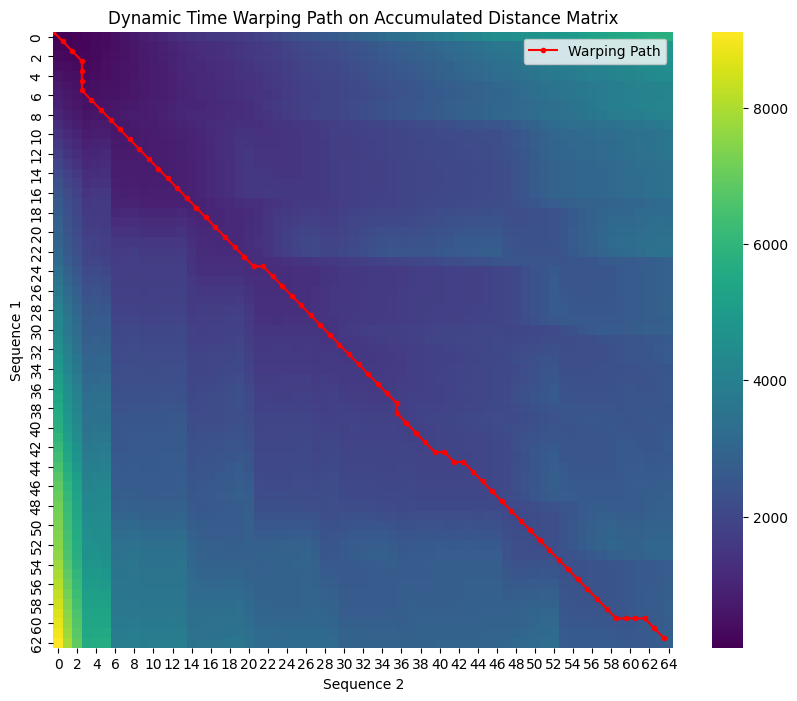

In [20]:
D, wp = calc_dtw(m1, m2)

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 8))

# Plot the distance matrix as a heatmap
sns.heatmap(D, cmap='viridis', cbar=True)

# Extract the x and y coordinates from the warping path
wp_x, wp_y = zip(*wp)

# Overlay the warping path
plt.plot(wp_y, wp_x, color='red', marker='o', markersize=3, linestyle='-', linewidth=1.5, label="Warping Path")

# Add labels and title
plt.xlabel("Sequence 2")
plt.ylabel("Sequence 1")
plt.title("Dynamic Time Warping Path on Accumulated Distance Matrix")
plt.legend()
plt.show()


In [21]:
bounds = map_boundaries(ref_stanzas[segment_index], wp) + [len(y2)]
print(bounds)
clips = [y2[start:end] for start, end in zip(bounds, bounds[1:])]
new_y = create_segmented_audio(clips)
sf.write('audio_syllables.ogg', new_y, SAMPLE_RATE, format='ogg', subtype='vorbis')


[0, 3727, 12179, 19027, 21626, 23742, 33369, 40935, 43040]


In [22]:
orig_bounds = [int((x - ref_stanzas[segment_index][0]) * sr) for x in ref_stanzas[segment_index]] + [len(y1)]
print(orig_bounds)
print([o / sr for o in orig_bounds])
orig_clips = [y1[start:end] for start, end in zip(orig_bounds, orig_bounds[1:])]
orig_y = create_segmented_audio(orig_clips)
# sf.write('audio_syllables.ogg', orig_y, SAMPLE_RATE, format='ogg', subtype='vorbis')


[0, 5647, 14099, 20307, 22906, 25662, 34009, 39655, 42338]
[0.0, 0.3529375, 0.8811875, 1.2691875, 1.431625, 1.603875, 2.1255625, 2.4784375, 2.646125]


### Dataset creation

In [23]:
directories = ['vs'] + ['vs' + str(i) for i in [1, 3, 4, 5, 6, 7, 9, 10, 11, 12, 14, 15, 16]]
all_bounds = {}

for dir in directories[1:]:
    print(dir)
    target_clips, target_meta = get_clips(dir)
    all_bounds[dir] = []
    for segment_index in range(441):
        # print(segment_index)
        y1 = ref_clips[segment_index]
        y2 = target_clips[segment_index]
        m1 = calculate_mfcc(y1, sr)
        m2 = calculate_mfcc(y2, sr)
        D, wp = calc_dtw(m1, m2)
        bounds = map_boundaries(ref_stanzas[segment_index], wp) + [len(y2)]
        all_bounds[dir].append(bounds)


vs1
vs3
vs4
vs5
vs6
vs7
vs9
vs10
vs11
vs12
vs14
vs15
vs16


In [24]:
len(ref_clips)

441

In [ ]:
# Create joined bounds
last = 0
bounds_joined = {}
for k in all_bounds:
    bounds_joined[k] = []
    last = 0
    for b in all_bounds[k]:
        bounds_joined[k].extend([i + last for i in b[:-1]]) # Omit the last, since next 0 will take care of it
        last += b[-1]

all_syllables = sum(line_breaks, [])
def bounds_to_labels(joined_bounds, filename):
    with open(filename, 'w') as f:
        idx = 0
        for b in joined_bounds:
            timestamp = b / sr
            f.write('{}\t{}\t{}\n'.format(timestamp, timestamp, all_syllables[idx]))
            idx += 1

for k in bounds_joined:
    print(k)
    bounds_to_labels(bounds_joined[k], './dataset/nama/'+k+'/syllable_labels.txt')

SyntaxError: unterminated string literal (detected at line 22) (2436059747.py, line 22)

In [ ]:
[len(b) for b in bounds_joined.values()]

[3535, 3535, 3535, 3535, 3535, 3535, 3535, 3535, 3535, 3535, 3535, 3535, 3535]

In [ ]:
sum(line_breaks, [])


['विश्',
 'वं',
 'विष्',
 'णुर्',
 'व',
 'षट्',
 'का',
 'रो',
 'भू',
 'त',
 'भव्',
 'य',
 'भ',
 'वत्',
 'प्र',
 'भुः',
 'भू',
 'त',
 'कृद्',
 'भू',
 'त',
 'भृद्',
 'भा',
 'वो',
 'भू',
 'तात्',
 'मा',
 'भू',
 'त',
 'भा',
 'व',
 'नः',
 'पू',
 'तात्',
 'मा',
 'प',
 'र',
 'मात्',
 'मा',
 'च',
 'मुक्',
 'ता',
 'नां',
 'प',
 'र',
 'मा',
 'ग',
 'तिः',
 'अव्',
 'य',
 'यः',
 'पु',
 'रु',
 'षः',
 'साक्',
 'षी',
 'क्षेत्',
 'रज्',
 'ञोक्',
 'ष',
 'र',
 'ए',
 'व',
 'च',
 'यो',
 'गो',
 'यो',
 'ग',
 'वि',
 'दां',
 'ने',
 'ता',
 'प्र',
 'धा',
 'न',
 'पु',
 'रु',
 'षेश्',
 'व',
 'रः',
 'ना',
 'र',
 'सिं',
 'ह',
 'व',
 'पुःश्',
 'री',
 'मान्',
 'के',
 'श',
 'वः',
 'पु',
 'रु',
 'षोत्',
 'त',
 'मः',
 'सर्',
 'वः',
 'शर्',
 'वः',
 'शि',
 'वःस्',
 'था',
 'णुर्',
 'भू',
 'ता',
 'दिर्',
 'नि',
 'धि',
 'रव्',
 'य',
 'यः',
 'सम्',
 'भ',
 'वो',
 'भा',
 'व',
 'नो',
 'भर्',
 'ता',
 'प्र',
 'भ',
 'वः',
 'प्र',
 'भु',
 'रीश्',
 'व',
 'रः',
 'स्व',
 'यम्',
 'भूः',
 'शम्',
 'भु',
 'रा',
 'दित्',
 'यः',
 'पुष्',
 'क'

## Can audio segment length be a feature?


In [ ]:
import numpy as np

In [ ]:

labels = []
for directory in directories:
    target_json_filename = f'./dataset/nama/{directory}/label.json'
    target_labels_json = json.loads(open(target_json_filename).read())
    labels.append(target_labels_json['fragments'])

In [ ]:
lengths = np.zeros((len(directories), len(labels[0])))
for i, line in enumerate(labels):
    for j, x in enumerate(line):
        lengths[i][j] = float(x['end']) - float(x['begin'])

In [ ]:
total_lengths = np.sum(lengths, axis=1)
print(total_lengths)
mean_length = np.mean(total_lengths)
min_length, max_length = min(total_lengths), max(total_lengths)
print(min_length, mean_length, max_length)
print((mean_length - min_length) * 100 / mean_length, (max_length - mean_length) * 100 / mean_length)

[1206.82 1151.3  1000.88  940.48 1000.58 1148.64  997.12 1175.92 1245.07
 1007.8  1543.92 1212.6  1409.08 1053.2 ]
940.48 1149.5292857142856 1543.92
18.185642446193803 34.30888792369053


In [ ]:
median_durations = np.median(lengths, axis=1)
median_durations = median_durations[:, np.newaxis]

lengths / total_lengths[:, np.newaxis]

array([[0.00221243, 0.00226214, 0.00223728, ..., 0.00255216, 0.00215442,
        0.00290018],
       [0.00236255, 0.00257101, 0.00199774, ..., 0.00215409, 0.00231043,
        0.00284895],
       [0.00275757, 0.00231796, 0.00203821, ..., 0.00241787, 0.00273759,
        0.00231796],
       ...,
       [0.00201221, 0.00192974, 0.00191324, ..., 0.00299357, 0.00245753,
        0.00301831],
       [0.00217163, 0.00242712, 0.00183098, ..., 0.00282454, 0.00211486,
        0.00208647],
       [0.00253513, 0.00209837, 0.0024022 , ..., 0.00305735, 0.00254463,
        0.00284846]])

In [ ]:
from matplotlib import pyplot as plt

%matplotlib inline

In [ ]:
2.73/2.45

1.114285714285714

In [ ]:
lengths

array([[2.67, 2.73, 2.7 , ..., 3.08, 2.6 , 3.5 ],
       [2.72, 2.96, 2.3 , ..., 2.48, 2.66, 3.28],
       [2.76, 2.32, 2.04, ..., 2.42, 2.74, 2.32],
       ...,
       [2.44, 2.34, 2.32, ..., 3.63, 2.98, 3.66],
       [3.06, 3.42, 2.58, ..., 3.98, 2.98, 2.94],
       [2.67, 2.21, 2.53, ..., 3.22, 2.68, 3.  ]])

In [ ]:
median_durations

array([[2.73],
       [2.56],
       [2.24],
       [2.14],
       [2.25],
       [2.6 ],
       [2.24],
       [2.65],
       [2.77],
       [2.28],
       [3.48],
       [2.74],
       [3.18],
       [2.36]])

In [ ]:
median_durations.shape

(14, 1)

(TODO)

## Clustering MFCCs

In [ ]:
y, js = get_clips('vs')

In [ ]:
all_segments = {}

for directory in directories:
    print(directory)
    ys, anno = get_clips(directory)
    all_segments[directory] = {}
    for i, y in enumerate(ys):
        all_segments[directory][i] = {'y': y, 'data': anno[i]}
        all_segments[directory][i]['mfcc'] = calculate_mfcc(y, SAMPLE_RATE)


vs
vs1
vs3
vs4
vs5
vs6
vs7
vs9
vs10
vs11
vs12
vs14
vs15
vs16


In [ ]:
all_segments['vs5'][0]['mfcc'].shape

(13, 68)

In [ ]:
all_mfccs = []
for directory in all_segments:
    for segment in all_segments[directory]:
        all_mfccs.append(all_segments[directory][segment]['mfcc'])
mfccs_data = np.concatenate(all_mfccs, axis=1).T

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
NUM_CLUSTERS = 5000
kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=42)
kmeans.fit(mfccs_data)


KMeans(n_clusters=5000, random_state=42)